<a href="https://colab.research.google.com/github/ninja941/ACTIVITY/blob/main/DSFAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os, io, zipfile, requests
from pathlib import Path

# Choose the corpus
corpus_name = "shakespeare"  # Change to "shakespeare", "wikipedia", or "math"

# Reliable sources:
# - shakespeare: Karpathy's tiny Shakespeare (plain text)
# - wikipedia: https://www.kaggle.com/datasets/ffatty/plain-text-wikipedia-simpleenglish
# - math: https://archive.org/stream/CalculusMadeEasy/Calculus_Made_Easy_Thompson_djvu.txt



# Download and show sample

text = Path(f"/content/drive/MyDrive/Lab 1 attached files Sep 3, 2025 439 PM/data/{corpus_name}.txt").read_text(encoding="utf-8", errors="ignore")
print(f"Corpus length: {len(text)} characters")
print("Sample:")
print(text[:300])

Corpus length: 1115394 characters
Sample:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [12]:
# -----------------------------------------
# Prepare dataset for character-level modeling
# -----------------------------------------

import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torch.utils.data import DataLoader

class CharDataset(Dataset):
    def __init__(self, text, block_size, stoi=None, itos=None):
        """
        text: The raw text string we want to train on.
        block_size: The length of each training sequence (number of characters).
        stoi, itos: Optional vocab mappings. If provided, reuse them.
        """

        # 1. Build or reuse the vocabulary
        if stoi is None or itos is None:
            # Build from scratch
            self.chars = sorted(list(set(text)))
            self.vocab_size = len(self.chars)
            self.stoi = {ch: i for i, ch in enumerate(self.chars)}
            self.itos = {i: ch for i, ch in enumerate(self.chars)}
        else:
            # Reuse given vocab
            self.stoi = stoi
            self.itos = itos
            self.vocab_size = len(self.stoi)

        # 2. Store sequence length
        self.block_size = block_size

        # 3. Encode dataset into indices
        #    Use .get(ch, 0) so unknown characters map to 0
        self.data = torch.tensor([self.stoi.get(c, 0) for c in text], dtype=torch.long)

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y


block_size = 64
text = Path(f"/content/drive/MyDrive/Lab 1 attached files Sep 3, 2025 439 PM/data/{corpus_name}.txt").read_text(encoding="utf-8", errors="ignore")
dataset = CharDataset(text, block_size=block_size, stoi=None, itos=None)

In [13]:
import sys
sys.path.append("/content/drive/MyDrive/Lab 1 attached files Sep 3, 2025 439 PM")
from nanogpt_model import GPT  # Import the GPT model class from the NanoGPT repo


# -----------------------------------------
# Define a configuration object for the GPT model
# -----------------------------------------
class GPTConfig:
    def __init__(self, vocab_size, block_size,
                 n_layer=2, n_head=2, n_embd=128, dropout=0.2, bias = True):


        # Store all parameters for use by the GPT class
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        self.bias = bias


config = GPTConfig(vocab_size=dataset.vocab_size, block_size=block_size)
model = GPT(config)
print(model)



number of parameters: 0.41M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65, 128)
    (wpe): Embedding(64, 128)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=True)
          (c_proj): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=65, bias=False)
)


In [21]:
import os
import collections
import matplotlib.pyplot as plt

def safe_label(c):
    try:
        c.encode("ascii")  # check if ASCII-printable
        return c
    except UnicodeEncodeError:
        return f"U+{ord(c):04X}"

def plot_char_histogram(text, corpus_name, top_n=30):
    os.makedirs("checkpoints", exist_ok=True)   # ✅ ensure checkpoints folder exists

    counts = collections.Counter(text)
    most_common = counts.most_common(top_n)

    labels = [safe_label(c) for c, _ in most_common]
    values = [v for _, v in most_common]

    plt.figure(figsize=(12,6))
    plt.bar(labels, values)
    plt.title(f"Character Frequency Histogram - {corpus_name}")
    plt.xlabel("Character")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()

    out_path = f"checkpoints/{corpus_name}_char_hist.png"
    plt.savefig(out_path)
    plt.show()
    print(f"✅ Saved histogram to {out_path}")


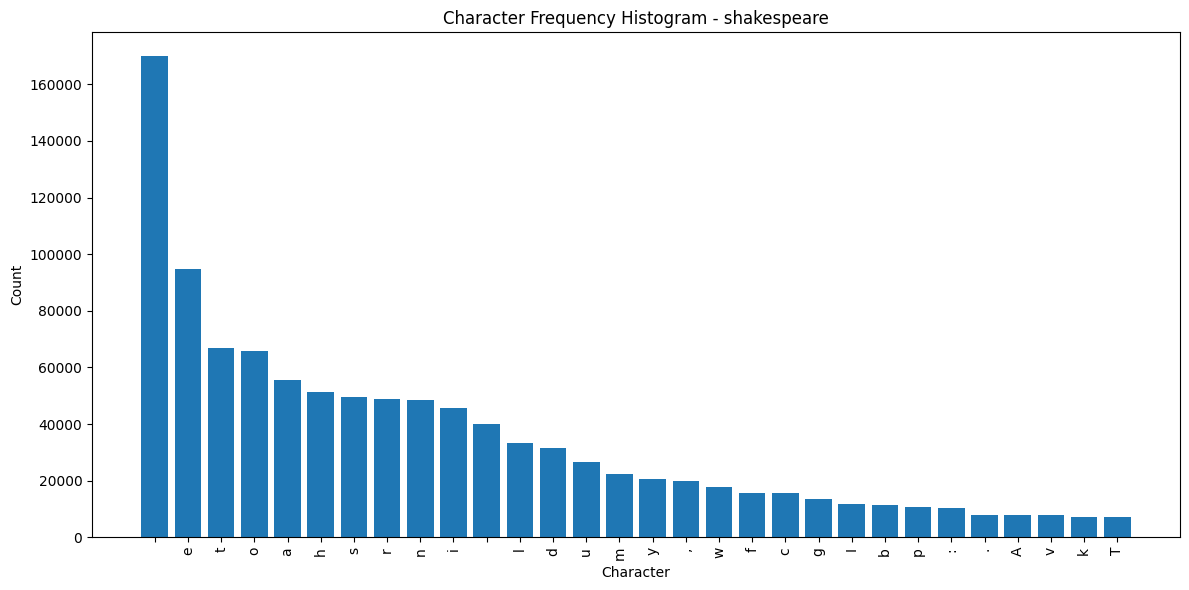

✅ Saved histogram to checkpoints/shakespeare_char_hist.png


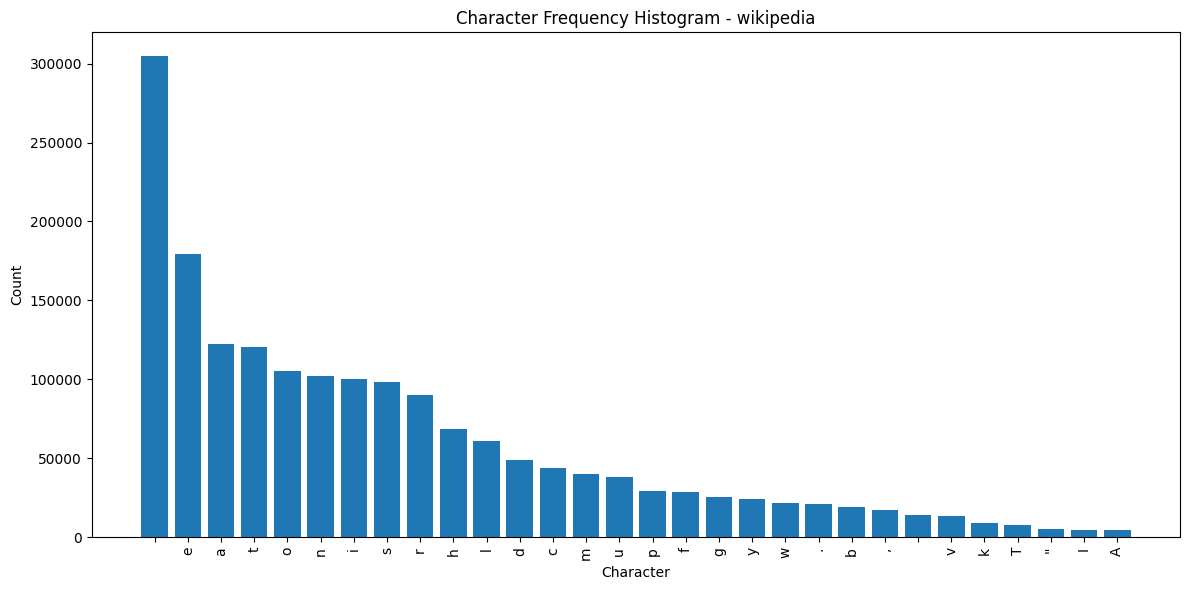

✅ Saved histogram to checkpoints/wikipedia_char_hist.png


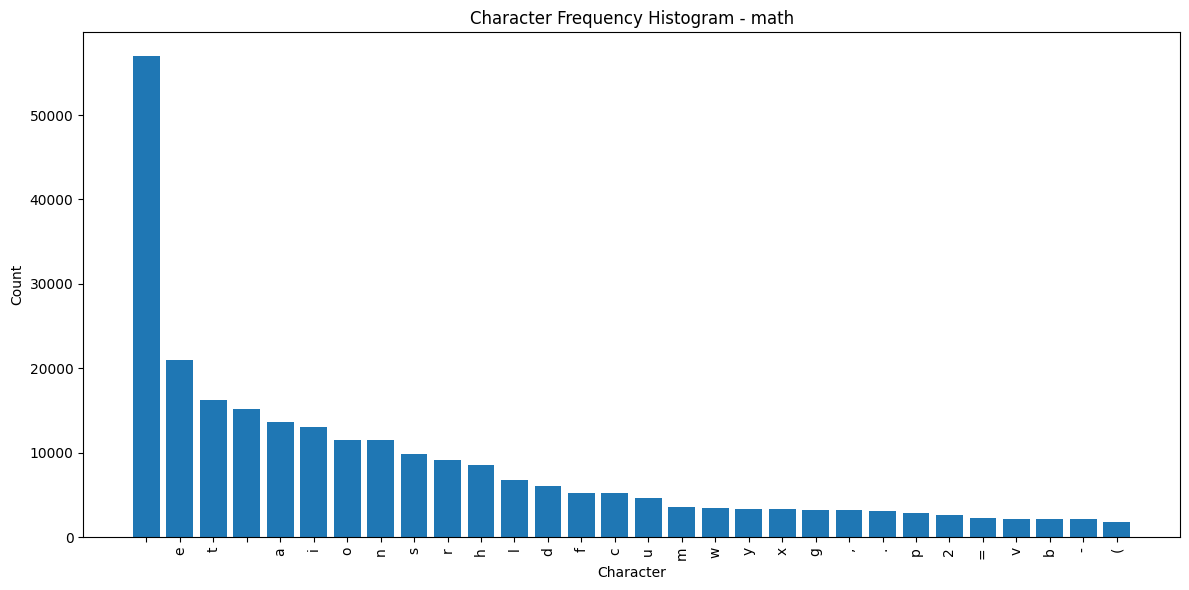

✅ Saved histogram to checkpoints/math_char_hist.png


In [15]:
plot_char_histogram(shakespeare_text, "shakespeare")
plot_char_histogram(wiki_text, "wikipedia")
plot_char_histogram(math_text, "math")

In [16]:
import os
import torch
from tqdm import tqdm
print(corpus_name)
# Directory for this corpus
ckpt_dir = os.path.join("checkpoints", corpus_name)
os.makedirs(ckpt_dir, exist_ok=True)
final_ckpt_path = os.path.join(ckpt_dir, "final.pt")

if os.path.exists(final_ckpt_path):
    print(f"Final checkpoint for '{corpus_name}' found at {final_ckpt_path}.")
    ckpt = torch.load(final_ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    losses = ckpt.get("losses", [])
    print(f"Loaded model with {len(losses)} stored loss values.")
else:
    print(f"No checkpoint found for '{corpus_name}', starting training...")
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    max_iters = 500

    losses = []   # will now store only full-batch eval losses
    model.train()
    for it in range(max_iters):
        xb, yb = next(iter(loader))

        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            # Evaluate on full dataset (avg loss across all batches)
            model.eval()
            eval_losses = []

            max_batches = len(loader) * 0.01
            for i, (xb_eval, yb_eval) in enumerate(loader):
                if i >= max_batches:  break
                logits_eval, loss_eval = model(xb_eval, yb_eval)
                eval_losses.append(loss_eval.item())
            avg_loss = torch.mean(torch.tensor(eval_losses))
            losses.append(avg_loss)
            print(f"Iter {it}/{max_iters}, Avg Loss over dataset: {avg_loss:.4f}")

            # Save periodic checkpoint
            iter_ckpt_path = os.path.join(ckpt_dir, f"iter_{it}.pt")
            torch.save({
                "model_state": model.state_dict(),
                "config": config.__dict__,
                "itos": dataset.itos,
                "stoi": dataset.stoi,
                "losses": losses
            }, iter_ckpt_path)
            print(f"Saved checkpoint: {iter_ckpt_path}")
            model.train()  # back to training mode

    # Save final checkpoint
    torch.save({
        "model_state": model.state_dict(),
        "config": config.__dict__,
        "itos": dataset.itos,
        "stoi": dataset.stoi,
        "losses": losses
    }, final_ckpt_path)
    print(f"Saved final model to {final_ckpt_path}")


shakespeare
No checkpoint found for 'shakespeare', starting training...
Iter 0/500, Avg Loss over dataset: 3.7834
Saved checkpoint: checkpoints/shakespeare/iter_0.pt
Iter 100/500, Avg Loss over dataset: 2.5118
Saved checkpoint: checkpoints/shakespeare/iter_100.pt
Iter 200/500, Avg Loss over dataset: 2.4509
Saved checkpoint: checkpoints/shakespeare/iter_200.pt
Iter 300/500, Avg Loss over dataset: 2.3680
Saved checkpoint: checkpoints/shakespeare/iter_300.pt
Iter 400/500, Avg Loss over dataset: 2.2605
Saved checkpoint: checkpoints/shakespeare/iter_400.pt
Saved final model to checkpoints/shakespeare/final.pt


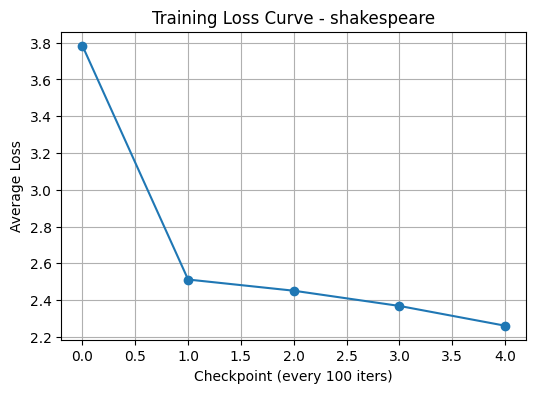

In [17]:
import matplotlib.pyplot as plt

# Plot training losses
plt.figure(figsize=(6,4))
plt.plot(losses, marker='o')
plt.xlabel("Checkpoint (every 100 iters)")
plt.ylabel("Average Loss")
plt.title(f"Training Loss Curve - {corpus_name}")
plt.grid(True)
plt.show()

In [18]:
ckpt = torch.load("checkpoints/shakespeare/final.pt", map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.eval()

context = torch.tensor([[dataset.stoi["T"]]], dtype=torch.long)  # seed with 'T'
out = model.generate(context, max_new_tokens=200)
print("Generated text:\n", ''.join([dataset.itos[int(i)] for i in out[0]]))

Generated text:
 TED Graug dist ma ty magualang.






Theme he dener, swars.

NKINTERANG LIOQIUK:
'TRDO:
Bume has minen with my the blow be, thet wisen shis:
This be grie he bom not and wher tLuchad whouk so roaot;
To


In [19]:
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(corpus_name)

ckpt_dir = os.path.join("checkpoints", corpus_name)
os.makedirs(ckpt_dir, exist_ok=True)
final_ckpt_path = os.path.join(ckpt_dir, "final.pt")

learning_rate = 3e-4
batch_size = 32
max_iters = 5000
eval_interval = 100
grad_clip = 1.0
top_k = 50
temperature = 0.7

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
start_iter = 0

if os.path.exists(final_ckpt_path):
    print(f"Checkpoint found for '{corpus_name}' at {final_ckpt_path}, resuming training...")
    ckpt = torch.load(final_ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt.get("optimizer_state", optimizer.state_dict()))
    losses = ckpt.get("losses", [])
    start_iter = ckpt.get("iter", 0)
    print(f"Resuming from iteration {start_iter}, with {len(losses)} stored loss values.")
else:
    print(f"No checkpoint found for '{corpus_name}', starting training from scratch...")

model.train()
for it in range(start_iter, max_iters):
    xb, yb = next(iter(loader))
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
    optimizer.step()

    if it % eval_interval == 0:
        model.eval()
        eval_losses = []
        max_batches = int(len(loader) * 0.01)
        for i, (xb_eval, yb_eval) in enumerate(loader):
            if i >= max_batches: break
            _, loss_eval = model(xb_eval, yb_eval)
            eval_losses.append(loss_eval.item())
        avg_loss = torch.mean(torch.tensor(eval_losses))
        losses.append(avg_loss)
        print(f"Iter {it}/{max_iters}, Avg Loss: {avg_loss:.4f}")

        iter_ckpt_path = os.path.join(ckpt_dir, f"iter_{it}.pt")
        torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "config": config.__dict__,
            "itos": dataset.itos,
            "stoi": dataset.stoi,
            "losses": losses,
            "iter": it
        }, iter_ckpt_path)
        print(f"Saved checkpoint: {iter_ckpt_path}")
        model.train()

torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "config": config.__dict__,
    "itos": dataset.itos,
    "stoi": dataset.stoi,
    "losses": losses,
    "iter": max_iters
}, final_ckpt_path)
print(f"Saved final model to {final_ckpt_path}")

def generate_text(model, start="TO:", max_new_tokens=200, temperature=0.7, top_k=50):
    model.eval()
    device = next(model.parameters()).device
    idx = torch.tensor([[dataset.stoi.get(s, 0) for s in start]], dtype=torch.long, device=device)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -config.block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        if top_k is not None:
            values, indices = torch.topk(probs, top_k)
            probs = torch.zeros_like(probs).scatter_(1, indices, values)
            probs /= probs.sum(dim=-1, keepdim=True)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)
    text = ''.join([dataset.itos[i] for i in idx[0].tolist()])
    return text

print("\nGenerated sample after training:")
print(generate_text(model, start="TO:", max_new_tokens=300, temperature=temperature, top_k=top_k))


shakespeare
Checkpoint found for 'shakespeare' at checkpoints/shakespeare/final.pt, resuming training...
Resuming from iteration 0, with 5 stored loss values.
Iter 0/5000, Avg Loss: 2.1819
Saved checkpoint: checkpoints/shakespeare/iter_0.pt
Iter 100/5000, Avg Loss: 2.1316
Saved checkpoint: checkpoints/shakespeare/iter_100.pt
Iter 200/5000, Avg Loss: 2.1144
Saved checkpoint: checkpoints/shakespeare/iter_200.pt
Iter 300/5000, Avg Loss: 2.0822
Saved checkpoint: checkpoints/shakespeare/iter_300.pt
Iter 400/5000, Avg Loss: 2.0637
Saved checkpoint: checkpoints/shakespeare/iter_400.pt
Iter 500/5000, Avg Loss: 2.0390
Saved checkpoint: checkpoints/shakespeare/iter_500.pt
Iter 600/5000, Avg Loss: 2.0227
Saved checkpoint: checkpoints/shakespeare/iter_600.pt
Iter 700/5000, Avg Loss: 2.0016
Saved checkpoint: checkpoints/shakespeare/iter_700.pt
Iter 800/5000, Avg Loss: 1.9865
Saved checkpoint: checkpoints/shakespeare/iter_800.pt
Iter 900/5000, Avg Loss: 1.9663
Saved checkpoint: checkpoints/shakespea

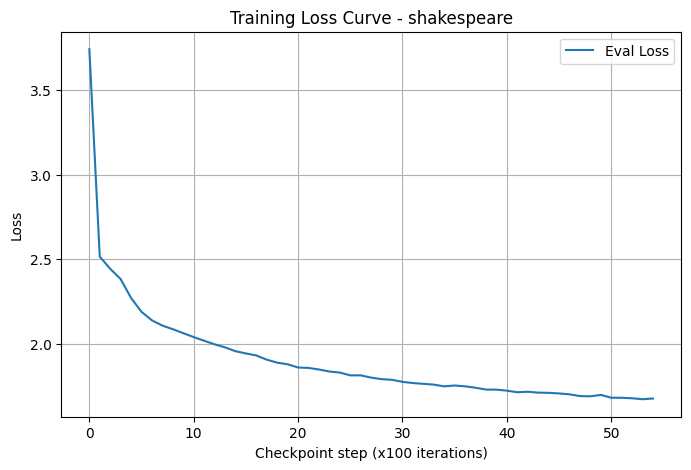

Loss curve saved to checkpoints/shakespeare/loss_curve_shakespeare.png


In [30]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(losses, label="Eval Loss")
plt.xlabel("Checkpoint step (x100 iterations)")
plt.ylabel("Loss")
plt.title(f"Training Loss Curve - {corpus_name}")
plt.legend()
plt.grid(True)

# Save the plot as an image
loss_plot_path = os.path.join(ckpt_dir, f"loss_curve_{corpus_name}.png")
plt.savefig(loss_plot_path)
plt.show()

print(f"Loss curve saved to {loss_plot_path}")

In [22]:
from google.colab import files
files.download("checkpoints/shakespeare/final.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
!zip -r shakespeare_checkpoints.zip checkpoints/shakespeare
files.download("shakespeare_checkpoints.zip")

  adding: checkpoints/shakespeare/ (stored 0%)
  adding: checkpoints/shakespeare/iter_1900.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_2900.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_700.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_1500.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_4000.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_1800.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_1400.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_200.pt (deflated 8%)
  adding: checkpoints/shakespeare/iter_600.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_100.pt (deflated 8%)
  adding: checkpoints/shakespeare/iter_1000.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_2600.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_2400.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_4200.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_2500.pt (deflated 9%)
  adding: checkpoints/shakespeare/iter_200

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import os, io, zipfile, requests
from pathlib import Path

# Choose the corpus
corpus_name = "wikipedia"  # Change to "shakespeare", "wikipedia", or "math"

# Reliable sources:
# - shakespeare: Karpathy's tiny Shakespeare (plain text)
# - wikipedia: https://www.kaggle.com/datasets/ffatty/plain-text-wikipedia-simpleenglish
# - math: https://archive.org/stream/CalculusMadeEasy/Calculus_Made_Easy_Thompson_djvu.txt



# Download and show sample

text = Path(f"/content/drive/MyDrive/Lab 1 attached files Sep 3, 2025 439 PM/data/{corpus_name}.txt").read_text(encoding="utf-8", errors="ignore")
print(f"Corpus length: {len(text)} characters")
print("Sample:")
print(text[:300])

Corpus length: 1842376 characters
Sample:
April

April (Apr.) is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May. It is one of four months to have 30 days.

April always begins on the same day of the week as July, and additionally, January in leap years. April always ends on the same day o


In [25]:
# -----------------------------------------
# Prepare dataset for character-level modeling
# -----------------------------------------

import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torch.utils.data import DataLoader

class CharDataset(Dataset):
    def __init__(self, text, block_size, stoi=None, itos=None):
        """
        text: The raw text string we want to train on.
        block_size: The length of each training sequence (number of characters).
        stoi, itos: Optional vocab mappings. If provided, reuse them.
        """

        # 1. Build or reuse the vocabulary
        if stoi is None or itos is None:
            # Build from scratch
            self.chars = sorted(list(set(text)))
            self.vocab_size = len(self.chars)
            self.stoi = {ch: i for i, ch in enumerate(self.chars)}
            self.itos = {i: ch for i, ch in enumerate(self.chars)}
        else:
            # Reuse given vocab
            self.stoi = stoi
            self.itos = itos
            self.vocab_size = len(self.stoi)

        # 2. Store sequence length
        self.block_size = block_size

        # 3. Encode dataset into indices
        #    Use .get(ch, 0) so unknown characters map to 0
        self.data = torch.tensor([self.stoi.get(c, 0) for c in text], dtype=torch.long)

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y


block_size = 64
text = Path(f"/content/drive/MyDrive/Lab 1 attached files Sep 3, 2025 439 PM/data/{corpus_name}.txt").read_text(encoding="utf-8", errors="ignore")
dataset = CharDataset(text, block_size=block_size, stoi=None, itos=None)

In [26]:
import sys
sys.path.append("/content/drive/MyDrive/Lab 1 attached files Sep 3, 2025 439 PM")
from nanogpt_model import GPT  # Import the GPT model class from the NanoGPT repo


# -----------------------------------------
# Define a configuration object for the GPT model
# -----------------------------------------
class GPTConfig:
    def __init__(self, vocab_size, block_size,
                 n_layer=2, n_head=2, n_embd=128, dropout=0.2, bias = True):


        # Store all parameters for use by the GPT class
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        self.bias = bias


config = GPTConfig(vocab_size=dataset.vocab_size, block_size=block_size)
model = GPT(config)
print(model)



number of parameters: 0.43M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(292, 128)
    (wpe): Embedding(64, 128)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=True)
          (c_proj): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=292, bias=False)
)


In [27]:
import os
import torch
from tqdm import tqdm
print(corpus_name)
# Directory for this corpus
ckpt_dir = os.path.join("checkpoints", corpus_name)
os.makedirs(ckpt_dir, exist_ok=True)
final_ckpt_path = os.path.join(ckpt_dir, "final.pt")

if os.path.exists(final_ckpt_path):
    print(f"Final checkpoint for '{corpus_name}' found at {final_ckpt_path}.")
    ckpt = torch.load(final_ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    losses = ckpt.get("losses", [])
    print(f"Loaded model with {len(losses)} stored loss values.")
else:
    print(f"No checkpoint found for '{corpus_name}', starting training...")
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    max_iters = 500

    losses = []   # will now store only full-batch eval losses
    model.train()
    for it in range(max_iters):
        xb, yb = next(iter(loader))

        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            # Evaluate on full dataset (avg loss across all batches)
            model.eval()
            eval_losses = []

            max_batches = len(loader) * 0.01
            for i, (xb_eval, yb_eval) in enumerate(loader):
                if i >= max_batches:  break
                logits_eval, loss_eval = model(xb_eval, yb_eval)
                eval_losses.append(loss_eval.item())
            avg_loss = torch.mean(torch.tensor(eval_losses))
            losses.append(avg_loss)
            print(f"Iter {it}/{max_iters}, Avg Loss over dataset: {avg_loss:.4f}")

            # Save periodic checkpoint
            iter_ckpt_path = os.path.join(ckpt_dir, f"iter_{it}.pt")
            torch.save({
                "model_state": model.state_dict(),
                "config": config.__dict__,
                "itos": dataset.itos,
                "stoi": dataset.stoi,
                "losses": losses
            }, iter_ckpt_path)
            print(f"Saved checkpoint: {iter_ckpt_path}")
            model.train()  # back to training mode

    # Save final checkpoint
    torch.save({
        "model_state": model.state_dict(),
        "config": config.__dict__,
        "itos": dataset.itos,
        "stoi": dataset.stoi,
        "losses": losses
    }, final_ckpt_path)
    print(f"Saved final model to {final_ckpt_path}")


wikipedia
No checkpoint found for 'wikipedia', starting training...
Iter 0/500, Avg Loss over dataset: 5.0970
Saved checkpoint: checkpoints/wikipedia/iter_0.pt
Iter 100/500, Avg Loss over dataset: 2.8683
Saved checkpoint: checkpoints/wikipedia/iter_100.pt
Iter 200/500, Avg Loss over dataset: 2.5655
Saved checkpoint: checkpoints/wikipedia/iter_200.pt
Iter 300/500, Avg Loss over dataset: 2.5013
Saved checkpoint: checkpoints/wikipedia/iter_300.pt
Iter 400/500, Avg Loss over dataset: 2.4653
Saved checkpoint: checkpoints/wikipedia/iter_400.pt
Saved final model to checkpoints/wikipedia/final.pt


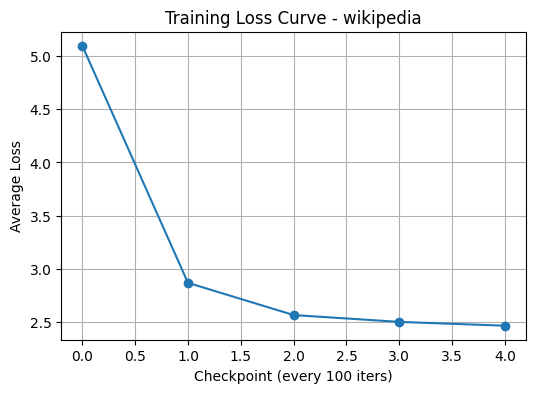

In [28]:
import matplotlib.pyplot as plt

# Plot training losses
plt.figure(figsize=(6,4))
plt.plot(losses, marker='o')
plt.xlabel("Checkpoint (every 100 iters)")
plt.ylabel("Average Loss")
plt.title(f"Training Loss Curve - {corpus_name}")
plt.grid(True)
plt.show()

In [31]:
ckpt = torch.load("checkpoints/wikipedia/final.pt", map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.eval()

context = torch.tensor([[dataset.stoi["T"]]], dtype=torch.long)  # seed with 'T'
out = model.generate(context, max_new_tokens=200)
print("Generated text:\n", ''.join([dataset.itos[int(i)] for i in out[0]]))

Generated text:
 The hen IIt an an nasegitass, inghe. Re ant tth das the omuson at wese-rand the rvtousl. T, leodn cerache tom e mang sof candend tibrs mins, domeestexmaro code thir ad buedelolero cale is the o argul a


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(corpus_name)

ckpt_dir = os.path.join("checkpoints", corpus_name)
os.makedirs(ckpt_dir, exist_ok=True)
final_ckpt_path = os.path.join(ckpt_dir, "final.pt")

learning_rate = 3e-4
batch_size = 32
max_iters = 5000
eval_interval = 100
grad_clip = 1.0
top_k = 50
temperature = 0.7

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
start_iter = 0

if os.path.exists(final_ckpt_path):
    print(f"Checkpoint found for '{corpus_name}' at {final_ckpt_path}, resuming training...")
    ckpt = torch.load(final_ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt.get("optimizer_state", optimizer.state_dict()))
    losses = ckpt.get("losses", [])
    start_iter = ckpt.get("iter", 0)
    print(f"Resuming from iteration {start_iter}, with {len(losses)} stored loss values.")
else:
    print(f"No checkpoint found for '{corpus_name}', starting training from scratch...")

model.train()
for it in range(start_iter, max_iters):
    xb, yb = next(iter(loader))
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
    optimizer.step()

    if it % eval_interval == 0:
        model.eval()
        eval_losses = []
        max_batches = int(len(loader) * 0.01)
        for i, (xb_eval, yb_eval) in enumerate(loader):
            if i >= max_batches: break
            _, loss_eval = model(xb_eval, yb_eval)
            eval_losses.append(loss_eval.item())
        avg_loss = torch.mean(torch.tensor(eval_losses))
        losses.append(avg_loss)
        print(f"Iter {it}/{max_iters}, Avg Loss: {avg_loss:.4f}")

        iter_ckpt_path = os.path.join(ckpt_dir, f"iter_{it}.pt")
        torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "config": config.__dict__,
            "itos": dataset.itos,
            "stoi": dataset.stoi,
            "losses": losses,
            "iter": it
        }, iter_ckpt_path)
        print(f"Saved checkpoint: {iter_ckpt_path}")
        model.train()

torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "config": config.__dict__,
    "itos": dataset.itos,
    "stoi": dataset.stoi,
    "losses": losses,
    "iter": max_iters
}, final_ckpt_path)
print(f"Saved final model to {final_ckpt_path}")

def generate_text(model, start="TO:", max_new_tokens=200, temperature=0.7, top_k=50):
    model.eval()
    device = next(model.parameters()).device
    idx = torch.tensor([[dataset.stoi.get(s, 0) for s in start]], dtype=torch.long, device=device)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -config.block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        if top_k is not None:
            values, indices = torch.topk(probs, top_k)
            probs = torch.zeros_like(probs).scatter_(1, indices, values)
            probs /= probs.sum(dim=-1, keepdim=True)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)
    text = ''.join([dataset.itos[i] for i in idx[0].tolist()])
    return text

print("\nGenerated sample after training:")
print(generate_text(model, start="TO:", max_new_tokens=300, temperature=temperature, top_k=top_k))


wikipedia
Checkpoint found for 'wikipedia' at checkpoints/wikipedia/final.pt, resuming training...
Resuming from iteration 0, with 5 stored loss values.
Iter 0/5000, Avg Loss: 2.4130
Saved checkpoint: checkpoints/wikipedia/iter_0.pt
